In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import copy
import torch
import torch.nn as nn
import torchvision.transforms.functional as T
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier

from pretrain import init, train
from configs import FCConfig, CAEConfig
from src.data.collators import fc_collator
from src.utils.utils import set_random_seed

from src.model.FullyConnectedAE import FCAutoencoder
from src.model.ConvolutionalAE import CNNAutoencoder

from src.data.dataset import get_train_dataset, get_val_dataset

In [2]:
RANDOM_STATE = 322
set_random_seed(RANDOM_STATE)

### Setting up some useful functions

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"


def draw_pretrain_plot(train_losses, val_losses):
    x = np.arange(len(train_losses))

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_losses, c="C0", label="train")
    plt.plot(x, val_losses, c="C1", label="val")
    plt.title("Pretrain model losses")
    plt.xlabel("Epoches")
    plt.ylabel("Loss")
    plt.semilogy()
    plt.legend()

@torch.no_grad()
def construct_grid(model, dataset, num_images=10, ids=None, f=None, collator=None):
    if ids is None:
        ids = np.random.randint(0, len(dataset), size=num_images)
    img_batch = torch.Tensor().to(device)
    restored_img_batch = torch.Tensor().to(device)
    for idx in ids:
        img, _ = dataset[idx]
        if collator is not None:
            img, _ = collator([(img, _)])
        else:
            img = img.unsqueeze(0)
        img = img.to(device, non_blocking=True)
        restored_img = model(img)
        if f is not None:
            img = f(img)
            restored_img = f(restored_img)
        img_batch = torch.cat([img_batch, img], dim=0)
        restored_img_batch = torch.cat([restored_img_batch,
                                        restored_img], dim=0)

    img_batch = make_grid(img_batch.cpu(), nrow=num_images, padding=1, normalize=True, value_range=(-1, 1))
    restored_img_batch = make_grid(restored_img_batch.cpu(), nrow=num_images, padding=1, normalize=True, value_range=(-1, 1))
    grid = torch.cat([img_batch, restored_img_batch], dim=1)
    return grid

def show_grid(grid, img_size=(5, 5)):
    fig, axs = plt.subplots(figsize=(5 * img_size[0], 5 * img_size[1]),
                            squeeze=False)
    grid = grid.detach()
    grid = T.to_pil_image(grid)
    axs[0, 0].imshow(grid)
    axs[0, 0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def pretrain(model, optimizer, criterion, scheduler, train_dataloader,
             val_dataloader, val_dataset, num_epoches, checkpoint_path, f=None, collator=None):
    train_losses = []
    val_losses = []
    for epoch in range(num_epoches):
        train_loss, val_loss = train(model, optimizer, criterion, scheduler,
                                     train_dataloader, val_dataloader, checkpoint_path,
                                     device=device, num_epoches=1)
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())

        clear_output()
        draw_pretrain_plot(train_losses, val_losses)
        grid = construct_grid(model, val_dataset, f=f, collator=collator)
        show_grid(grid)
        plt.show()

def experiment(config, model_constructor, img_reshaper=None, data_collator=None):
    model, optimizer, criterion, scheduler = init(config, model_constructor)
    model.to(device)

    train_dataset = get_train_dataset("../data", False)
    val_dataset = get_val_dataset("../data", False)
    train_dataloader = DataLoader(train_dataset, config.train_config.train_batch_size, shuffle=True,
                                  num_workers=6, collate_fn=data_collator, pin_memory=True, drop_last=True)
    val_dataloader = DataLoader(val_dataset, config.train_config.eval_batch_size, shuffle=False,
                                num_workers=6, collate_fn=data_collator, pin_memory=True)


    pretrain(model, optimizer, criterion, scheduler, train_dataloader, val_dataloader,
             val_dataset, config.train_config.num_epoches,
             config.train_config.checkpoint_path, img_reshaper, data_collator)
    return model

/home/ivan/anaconda3/envs/local_colab/lib/python3.8/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /opt/conda/conda-bld/pytorch_1666642975312/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
neighbours_set = np.linspace(5, 100, 10).astype(np.int32)

def find_hyperparam(X_train, y_train):
    folds = 10
    kf = KFold(n_splits=folds, random_state=RANDOM_STATE, shuffle=True)
    acc = []
    for neighbours in neighbours_set:
        acc.append(0)
        for train_index, test_index in kf.split(X_train):
            X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
            y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
            model = KNeighborsClassifier(n_neighbors=neighbours, n_jobs=8).fit(X_train_cv, y_train_cv)
            y_pred = model.predict(X_test_cv)
            y_pred = torch.tensor(y_pred, device=y_test_cv.device)
            acc[-1] += torch.mean((y_test_cv == y_pred).float())
        acc[-1] /= folds

    return neighbours_set[np.array(acc).argmax()]

def knn_based_accuracy(X_train, y_train, n_neighbours):
    folds = 5
    kf = KFold(n_splits=folds, random_state=RANDOM_STATE, shuffle=True)
    acc = []
    for train_index, test_index in kf.split(X_train):
        X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
        y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
        model = KNeighborsClassifier(n_neighbors=n_neighbours, n_jobs=8).fit(X_train_cv, y_train_cv)
        y_pred = model.predict(X_test_cv)
        y_pred = torch.tensor(y_pred, device=y_test_cv.device)
        acc.append(torch.mean((y_test_cv == y_pred).float()).item())

    return np.mean(acc)

### Pretraining

#### Fully connected autoencoder

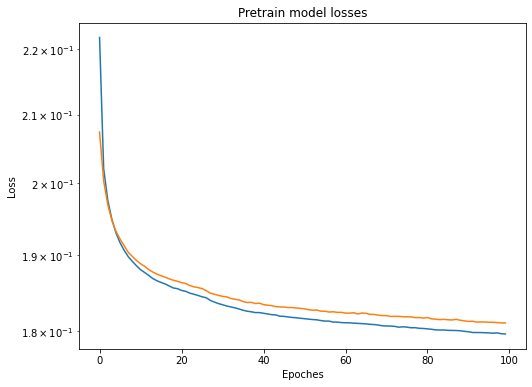

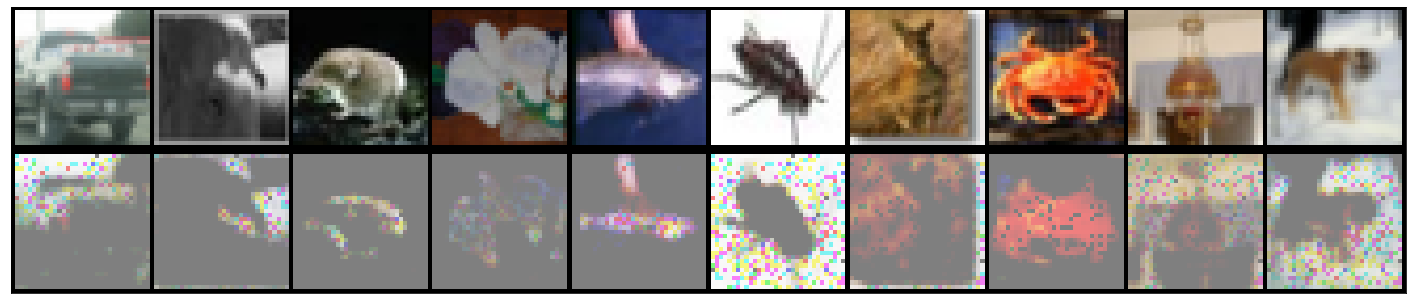

In [3]:
config = FCConfig
constructor = FCAutoencoder
fc_image_reshaper = lambda img: img.view(3, 32, 32)
experiment(config, constructor, fc_image_reshaper, fc_collator)


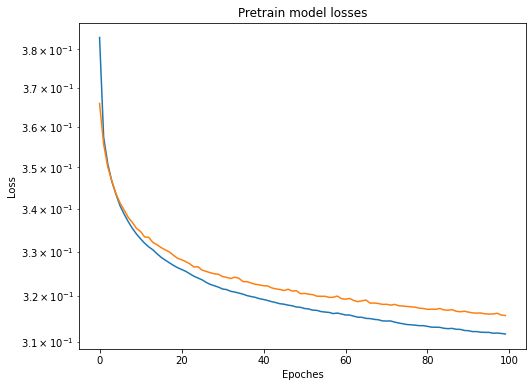

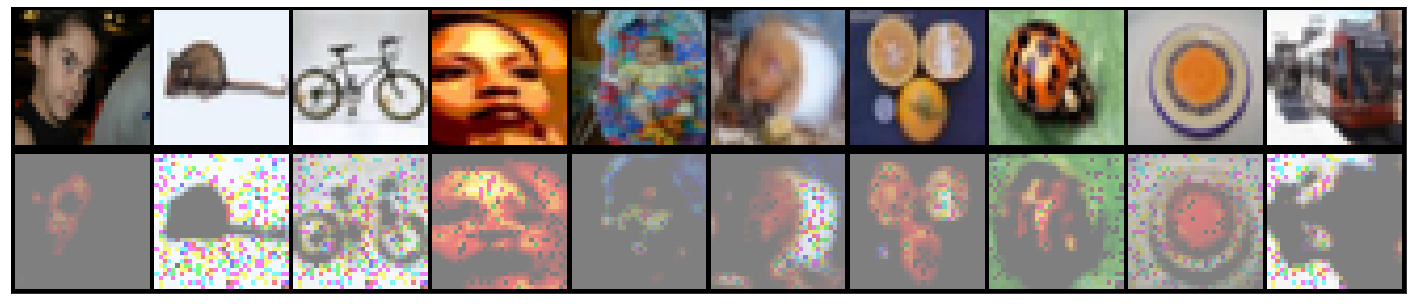

In [5]:
l1_config = copy.deepcopy(FCConfig)
l1_config.train_config.loss = nn.L1Loss
experiment(l1_config, constructor, fc_image_reshaper, fc_collator)


#### Convolutional-based autoencoder

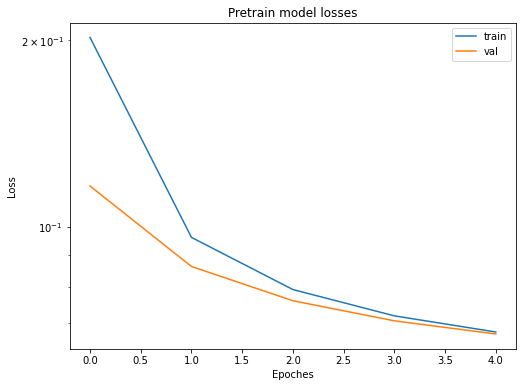

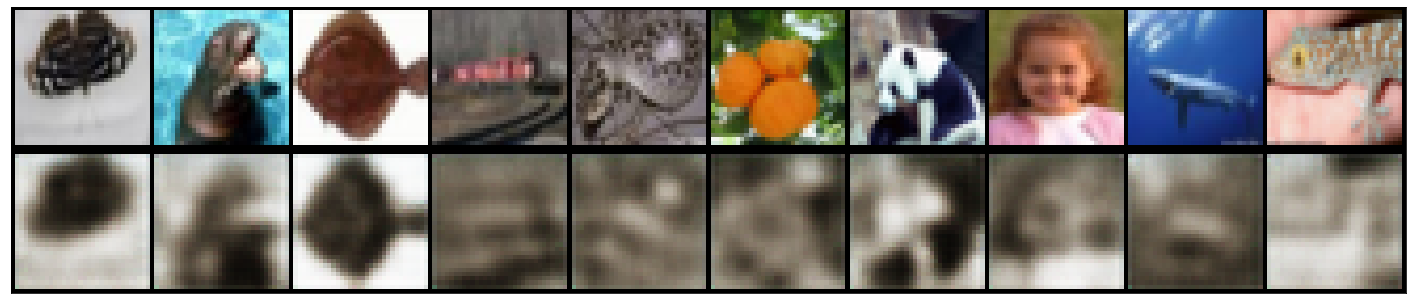

epoch loss: 0.06548646837472916:  40%|███▉      | 621/1562 [00:13<00:26, 35.49it/s]

In [ ]:
N_variants = 5
config_params = {
    "encoder_n_layers": [4, 4, 4, 5, 3],
    "encoder_scale_factor": [2, 3, 2, 2, 2],
    "decoder_n_layers": [4, 4, 4, 5, 3],
    "decoder_scale_factor": [2, 3, 2, 2, 2],
    "start_num_filters": [6, 6, 8, 8, 16],
}
constructor = CNNAutoencoder

metrics = []
params_count = []
inner_dim = []
for i in range(N_variants):
    experiment_cfg = copy.deepcopy(CAEConfig)
    for param in config_params.keys():
        setattr(experiment_cfg.model_config, param, config_params[param][i])

    model = experiment(experiment_cfg, constructor)

    clear_output()
    val_dataset = get_val_dataset("../data", False)
    val_dataloader = DataLoader(val_dataset, FCConfig.train_config.eval_batch_size, shuffle=True,
                                num_workers=6, pin_memory=True)
    X = torch.Tensor().to(device)
    y = torch.Tensor().to(device)
    with torch.no_grad():
        for batch, targets in val_dataloader:
            batch = batch.to(device, non_blocking=True)
            X = torch.cat([X, model.encode(batch)], dim=0)
            y = torch.cat([y, targets], dim=0)
    n_neighbours = find_hyperparam(X, y)
    accuracy = knn_based_accuracy(X, y, n_neighbours)
    metrics.append(accuracy)
    params_count.append(sum([p.numel() for p in model.parameters() if p.requires_grad]))
    inner_dim.append(np.prod(model.encode(val_dataset[0][0].unsqueeze(0)).shape))

torch.save(metrics, "metrics.pt")
torch.save(params_count, "params.pt")
torch.save(inner_dim, "inner_dim.pt")

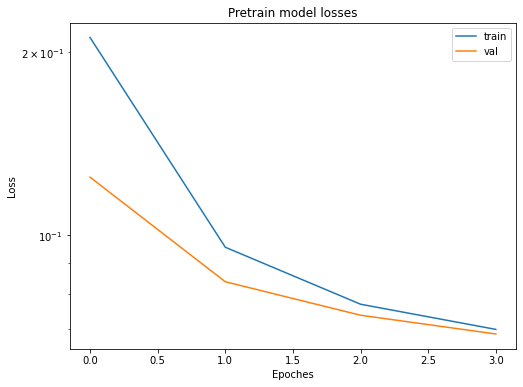

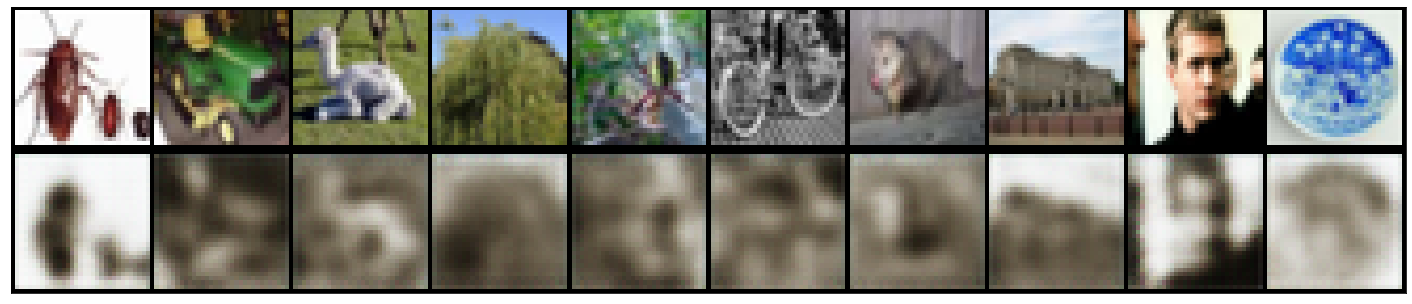

epoch loss: 0.06695879995822906:  46%|████▌     | 714/1562 [00:12<00:14, 57.50it/s]


KeyboardInterrupt: 

In [3]:
model, optimizer, criterion, scheduler = init(CAEConfig, CNNAutoencoder)
model.to(device)

train_dataset = get_train_dataset("../data", False)
val_dataset = get_val_dataset("../data", False)
train_dataloader = DataLoader(train_dataset, CAEConfig.train_config.train_batch_size, shuffle=True,
                              num_workers=6, pin_memory=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, CAEConfig.train_config.eval_batch_size, shuffle=False,
                            num_workers=6, pin_memory=True)


pretrain(model, optimizer, criterion, scheduler, train_dataloader, val_dataloader,
         val_dataset, CAEConfig.train_config.num_epoches,
         CAEConfig.train_config.checkpoint_path)

In [4]:
from torchsummary import summary

summary(model, (3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 16, 16]             294
         LeakyReLU-2            [-1, 6, 16, 16]               0
            Conv2d-3             [-1, 12, 8, 8]           1,164
         LeakyReLU-4             [-1, 12, 8, 8]               0
         LayerNorm-5             [-1, 12, 8, 8]              24
            Conv2d-6             [-1, 24, 4, 4]           4,632
         LeakyReLU-7             [-1, 24, 4, 4]               0
         LayerNorm-8             [-1, 24, 4, 4]              48
            Conv2d-9             [-1, 48, 2, 2]          18,480
        LeakyReLU-10             [-1, 48, 2, 2]               0
        LayerNorm-11             [-1, 48, 2, 2]              96
          Flatten-12                  [-1, 192]               0
       CNNEncoder-13                  [-1, 192]               0
  ConvTranspose2d-14             [-1, 2